## Demo_Landscape
This is a demo for visualizing the Landscape of a Neuron Network

To run this demo from scratch, you need first generate a BadNet attack result by using the following cell

In [ ]:
! python ../../attack/badnet.py --save_folder_name badnet_demo

or run the following command in your terminal

```python attack/badnet.py --save_folder_name badnet_demo```

**Remark**: **Message Passing Interface (MPI)** is needed to accelerate the computation of loss landscape. 

To install it, you can run the following commands in your terminal:

```sudo apt install libopenmpi-dev```

```pip install mpi4py```

Finally, you need also clone the repo https://github.com/tomgoldstein/loss-landscape to the ***visualization*** folder.

For more information, please refer to ***readme file***.

### Step 1: Import modules and set arguments

In [1]:
import sys, os
import yaml
import torch
import numpy as np
import torchvision.transforms as transforms
import socket
sys.path.append("../")
sys.path.append("../../")
sys.path.append("../loss-landscape")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.fix_random import fix_random
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.save_load_attack import load_attack_result
from utils.defense_utils.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from utils.defense_utils.dbd.model.model import SelfModel, LinearModel

import projection as proj
import net_plotter as net_plotter
import plot_2D as plot_2D
import plot_surface as plot_surface


/usr/local/anaconda3/envs/py38/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_hip.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
### Basic setting: args
args = get_args(True)

########## For Demo Only ##########
args.yaml_path = "../../"+args.yaml_path
args.result_file_attack = "badnet_demo"
######## End For Demo Only ##########

with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../..//record/" + args.result_file_attack


### Step 2: Load data

In [3]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
selected_classes = np.arange(args.num_classes)

# keep the same transforms for train and test dataset for better visualization
result_attack["clean_train"].wrap_img_transform = result_attack["clean_test"].wrap_img_transform 
result_attack["bd_train"].wrap_img_transform = result_attack["bd_test"].wrap_img_transform 

# Create dataset
args.visual_dataset = 'clean_train'
if args.visual_dataset == 'clean_train':
    visual_dataset = result_attack["clean_train"]
elif args.visual_dataset == 'bd_train':  
    visual_dataset = result_attack["bd_train"]
    visual_dataset.getitem_all = False # only return img and label
    
else:
    assert False, "Illegal vis_class"

print(f'Create visualization dataset with \n \t Dataset: {args.visual_dataset} \n \t Number of samples: {len(visual_dataset)}  \n \t Selected classes: {selected_classes}')

# Create data loader
data_loader = torch.utils.data.DataLoader(
    visual_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

# Create denormalization function
for trans_t in data_loader.dataset.wrap_img_transform.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)



Files already downloaded and verified
Files already downloaded and verified
loading...
Create visualization dataset with 
 	 Dataset: clean_train 
 	 Number of samples: 50000  
 	 Selected classes: [0 1 2 3 4 5 6 7 8 9]


### Step 3: Load Model

In [4]:
# Load model
model_visual = generate_cls_model(args.model, args.num_classes)
model_visual.load_state_dict(result_attack["model"])
model_visual
# !!! Important to set eval mode !!!
model_visual.eval()
print(f"Load model {args.model} from {args.result_file_attack}")

Load model preactresnet18 from badnet_demo


### Step 4: Setup parameters for Loss Landscape

In [5]:
import mpi4pytorch as mpi

# Set range for landscape
args.x = '-1:1:5'
args.y = '-1:1:5'

# Additional Agrs for Loss Landscape
args.mpi=True
args.cuda=True
args.show = False
args.model_file = save_path_attack
args.model_file1 = ""
args.model_fil2 = ""
args.data_split = 0
args.proj_file = ""

#--------------------------------------------------------------------------
# Environment setup
#--------------------------------------------------------------------------

if args.mpi:
    comm = mpi.setup_MPI()
    rank, nproc = comm.Get_rank(), comm.Get_size()
else:
    comm, rank, nproc = None, 0, 1

# in case of multiple GPUs per node, set the GPU to use for each rank
if args.cuda:
    if not torch.cuda.is_available():
        raise Exception('User selected cuda option, but cuda is not available on this machine')
    gpu_count = torch.cuda.device_count()
    torch.cuda.set_device(rank % gpu_count)
    print('Rank %d use GPU %d of %d GPUs on %s' %
          (rank, torch.cuda.current_device(), gpu_count, socket.gethostname()))
    
#--------------------------------------------------------------------------
# Check plotting resolution
#--------------------------------------------------------------------------
try:
    args.xmin, args.xmax, args.xnum = [float(a) for a in args.x.split(':')]
    args.ymin, args.ymax, args.ynum = (None, None, None)
    args.xnum = int(args.xnum)
    if args.y:
        args.ymin, args.ymax, args.ynum = [float(a) for a in args.y.split(':')]
        assert args.ymin and args.ymax and args.ynum, \
        'You specified some arguments for the y axis, but not all'
        args.ynum = int(args.ynum)
except:
    raise Exception('Improper format for x- or y-coordinates. Try something like -1:1:51')

Rank 0 use GPU 0 of 8 GPUs on ai07


No protocol specified


### Step 5: Setup directions

In [6]:
#--------------------------------------------------------------------------
# Extract model parameters
#--------------------------------------------------------------------------
w = net_plotter.get_weights(model_visual) # initial parameters
s = copy.deepcopy(model_visual.state_dict()) # deepcopy since state_dict are references
if args.ngpu > 1:
    # data parallel with multiple GPUs on a single node
    net = torch.nn.DataParallel(model_visual, device_ids=range(torch.cuda.device_count()))


#--------------------------------------------------------------------------
# Setup the direction file and the surface file
#--------------------------------------------------------------------------
dir_file = net_plotter.name_direction_file(args) # name the direction file
if rank == 0:
    net_plotter.setup_direction(args, dir_file, model_visual)

surf_file = plot_surface.name_surface_file(args, dir_file)
if rank == 0:
    plot_surface.setup_surface_file(args, surf_file, dir_file)

-------------------------------------------------------------------
setup_direction
-------------------------------------------------------------------
../..//record/badnet_demo_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5 is already setted up
../..//record/badnet_demo_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5_[-1.0,1.0,5]x[-1.0,1.0,5].h5 is already set up


In [7]:
# load directions
d = net_plotter.load_directions(dir_file)
# calculate the consine similarity of the two directions
if len(d) == 2 and rank == 0:
    similarity = proj.cal_angle(proj.nplist_to_tensor(d[0]), proj.nplist_to_tensor(d[1]))
    print('cosine similarity between x-axis and y-axis: %f' % similarity)


cosine similarity between x-axis and y-axis: -0.000373


### Step 6: Computation

In [8]:
#--------------------------------------------------------------------------
# Start the computation
#--------------------------------------------------------------------------
plot_surface.crunch(surf_file, model_visual, w, s, d, data_loader, 'train_loss', 'train_acc', comm, rank, args)


Computing 0 values for rank 0
Rank 0 done!  Total time: 0.00 Sync: 0.00


### Step 7: Show the Landscape

Text(0.5, 0, 'z')

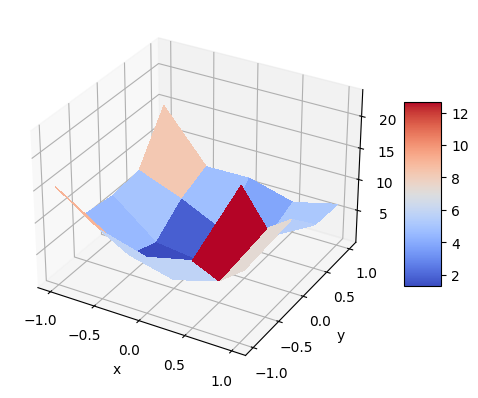

In [9]:
#--------------------------------------------------------------------------
# Plot figures
#--------------------------------------------------------------------------

import h5py
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

f = h5py.File(surf_file, 'r')
x = np.array(f['xcoordinates'][:])
y = np.array(f['ycoordinates'][:])
X, Y = np.meshgrid(x, y)

surf_name = "train_loss"

if surf_name in f.keys():
    Z = np.array(f[surf_name][:])
elif surf_name == 'train_err' or surf_name == 'test_err' :
    Z = 100 - np.array(f[surf_name][:])
else:
    print ('%s is not found in %s' % (surf_name, surf_file))

# --------------------------------------------------------------------
# Plot 3D surface
# --------------------------
fig = plt.figure()

def Axes3D(fig):
    return fig.add_subplot(projection='3d')
ax = Axes3D(fig)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')



In [ ]:
# Another way to show the results is the function provided by plot_2D
if rank == 0:
    args.vmin = 0.1 
    args.vmax = 10 
    args.vlevel = 0.5    
    if args.y and args.proj_file:
        plot_2D.plot_contour_trajectory(surf_file, dir_file, args.proj_file, 'train_loss', args.show)
    elif args.y:
        plot_2D.plot_2d_contour(surf_file, 'train_loss', args.vmin, args.vmax, args.vlevel, args.show)
    else:
        plot_1D.plot_1d_loss_err(surf_file, args.xmin, args.xmax, args.loss_max, args.log, args.show)
